In [2]:
import torch 
import os 
from torch import nn
import albumentations as A
import numpy as np

In [2]:
root_model = 'loaded_models'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def load_model(root:str , name:str) :
    path = os.path.join(root, name)
    model_dict = torch.load(path , map_location=device)
    print(model_dict.keys())
    return model_dict

In [4]:
model_dict = load_model(root_model ,'slow_fast_info_main.pt')

dict_keys(['model', 'epoch', 'optimizer', 'train_loss_list', 'val_loss_list'])


In [5]:
model_state, epoch, optimizer_state , train_losses, val_losses = (
    model_dict['model'],
    model_dict['epoch'],
    model_dict['optimizer'],
    model_dict['train_loss_list'],
    model_dict['val_loss_list']
)

In [6]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50' , pretrained=True)
in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = nn.Linear(in_features , 1)

Using cache found in C:\Users\alchemist/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [7]:
model.load_state_dict(model_state)

<All keys matched successfully>

In [8]:
from collections import deque
frame_queue = deque(maxlen=30)
frame_queue , list(frame_queue)

(deque([], maxlen=30), [])

In [9]:
def transform_data(data:torch.tensor , pathway_alpha):
        def pack_pathway_output(frames, alpha):
            fast_pathway = frames
            slow_pathway = frames[:, :, ::alpha, :, :]  # temporal subsampling
            return [slow_pathway, fast_pathway]
    
        def padd_to_32(data:torch.tensor) : 
            T = data.shape[2]
            if T == 32 : 
                return data 
            elif T < 32: 
                padd = 32 - T 
                st1 =  data[:,:,-1:,:,:].repeat(1, 1, padd , 1, 1)
                stacked = torch.cat([st1, data] , dim=2)
                return stacked
            else: 
                return data[:, :, :32, : , :] 

        transform = A.Compose([
            A.SmallestMaxSize(max_size=256),  
            A.CenterCrop(height=224, width=224),
            A.Normalize(mean=[0.45]*3, std=[0.225]*3),
        ])


        # input shape N, C , D , H , W 
        padd_data = padd_to_32(data)
        p_data = padd_data.permute(0, 2 , 1, 3 ,4)
        N, D, C, H, W = p_data.shape
        r_data = p_data.reshape(N * D , H, W , C)
        n_data = r_data.cpu().numpy()
        augmented = transform(images=n_data)
        augmented_video_frames = augmented['images']
        D, H , W , C = augmented_video_frames.shape # for test i need that since i didn't resize it with cv like training 
        data = augmented_video_frames.reshape(N, D , C , H , W)  
        data = data.transpose(0 , 2 , 1, 3, 4)
        data = torch.from_numpy(data).to(device)
        data = pack_pathway_output(data , pathway_alpha)   # this transofrms frame to slow and fast double frames 
        
        return data

In [21]:
from collections import deque
import torch
import cv2 as cv
import numpy as np 
frame_queue = deque(maxlen=25)  
cap = cv.VideoCapture('test_data/vid/none_test1.mp4')
counter = 0 
while True:
    is_playing, frame = cap.read()
    if not is_playing:
        break
    counter+=1

    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame_tensor = torch.tensor(frame_rgb)
    frame_queue.append(frame_tensor)

    if len(frame_queue) == 25:
        s_frame = torch.stack(list(frame_queue))
        b_frame = s_frame.unsqueeze(0) 
        per_frame = b_frame.permute(0, 4, 1, 2, 3)
        data = transform_data(per_frame, 4)

        with torch.inference_mode():
            pred = model(data)
            prob = torch.sigmoid(pred).item()
            print(prob)

        # text = f"Fire prob: {prob:.2f}"
        # cv.putText(frame, text, (10, 30), cv.FONT_HERSHEY_SIMPLEX,
        #            1, (0, 0, 255), 2, cv.LINE_AA)
        # frame_queue.clear()
    # cv.imshow('video', frame)

    # if cv.waitKey(1) & 0xFF == ord('q'):
        # break

cap.release()
# cv.destroyAllWindows()



0.99998939037323


In [11]:
len(val_losses) , epoch

(38, 37)

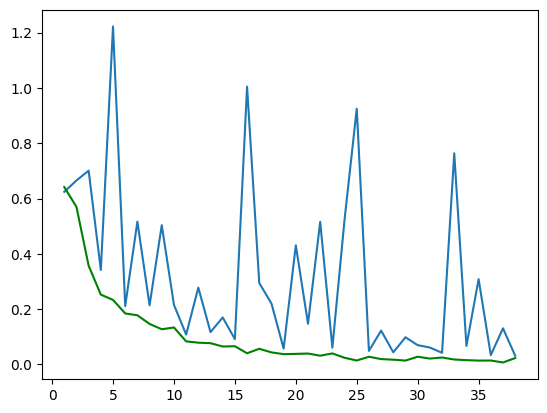

In [12]:
import matplotlib.pyplot as plt 
fig , axes = plt.subplots()
axes.plot(range(1 , epoch+2), val_losses)
axes.plot(range(1, epoch + 2) , train_losses , color = 'green')

In [ ]:
def __getitem__(self, idx):
    chunk_path, label = self.samples[idx]
    image_files = sorted(os.listdir(chunk_path))[:self.chunk_size]  # sort to keep frame order

    frames = []
    for fname in image_files:
        img_path = os.path.join(chunk_path, fname)
        img = Image.open(img_path).convert("RGB")  # ensure 3 channels
        img_np = np.array(img)

        # Albumentations expects NumPy array
        augmented = self.transform(image=img_np)['image']

        # Convert to torch tensor and reshape to [C, H, W]
        tensor_img = torch.from_numpy(augmented).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        frames.append(tensor_img)

    # Stack along time dimension: [T, C, H, W] → transpose to [C, T, H, W]
    video_tensor = torch.stack(frames, dim=0).permute(1, 0, 2, 3)

    return video_tensor.float(), torch.tensor(label, dtype=torch.float32)


In [44]:
torch.random.seed()
test = torch.randint(0 , 10 , (2 , 3 ,4 ))
test

tensor([[[9, 2, 5, 6],
         [7, 0, 3, 0],
         [1, 4, 7, 4]],

        [[1, 5, 0, 6],
         [9, 5, 5, 7],
         [1, 6, 3, 9]]])

In [45]:
batch , size , depth  = test.shape
batch , size , depth

(2, 3, 4)

In [50]:
trans_test= torch.permute(test , (0, 2 , 1))
trans_test , trans_test.shape

(tensor([[[9, 7, 1],
          [2, 0, 4],
          [5, 3, 7],
          [6, 0, 4]],
 
         [[1, 9, 1],
          [5, 5, 6],
          [0, 5, 3],
          [6, 7, 9]]]),
 torch.Size([2, 4, 3]))

In [51]:
B , D , S = trans_test.shape

In [55]:
reshaped_test = trans_test.reshape(B*D , S)
reshaped_test , reshaped_test.shape

(tensor([[9, 7, 1],
         [2, 0, 4],
         [5, 3, 7],
         [6, 0, 4],
         [1, 9, 1],
         [5, 5, 6],
         [0, 5, 3],
         [6, 7, 9]]),
 torch.Size([8, 3]))

In [57]:
reshaped_test = reshaped_test.reshape(B , D , S)
reshaped_test

tensor([[[9, 7, 1],
         [2, 0, 4],
         [5, 3, 7],
         [6, 0, 4]],

        [[1, 9, 1],
         [5, 5, 6],
         [0, 5, 3],
         [6, 7, 9]]])

In [58]:
reshaped_test.shape

torch.Size([2, 4, 3])

In [60]:
final_test = reshaped_test.permute(0 ,2 , 1)
final_test.shape

torch.Size([2, 3, 4])

In [62]:
final_test

tensor([[[9, 2, 5, 6],
         [7, 0, 3, 0],
         [1, 4, 7, 4]],

        [[1, 5, 0, 6],
         [9, 5, 5, 7],
         [1, 6, 3, 9]]])

In [63]:
test

tensor([[[9, 2, 5, 6],
         [7, 0, 3, 0],
         [1, 4, 7, 4]],

        [[1, 5, 0, 6],
         [9, 5, 5, 7],
         [1, 6, 3, 9]]])

In [8]:
import torch 
from utils.checkpoint import Checkpoint

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [18]:
checkpoint = Checkpoint(device)
model_dict = checkpoint.load('loaded_models', 'slow_fast_info_main.pt')

In [19]:
model_dict['epoch']

37